<a href="https://colab.research.google.com/github/sambeel/Lung-Cancer-Detection/blob/main/Lung_Cancer_Detection_New.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input, GlobalAvgPool2D, BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import time
import tifffile

import math
import shutil
import glob

import warnings
warnings.filterwarnings('ignore')



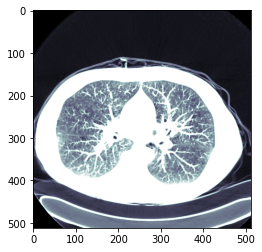

In [ ]:
BASE_DIR = "/content/drive/MyDrive/Datasets/JPG_IMG/"
CANCER_PATH = BASE_DIR+"cancer/"
NO_CANCER_PATH = BASE_DIR+"no_cancer/"
JPG_PATH = BASE_DIR

img1 = plt.imread(CANCER_PATH+"ID_0000_AGE_0060_CONTRAST_1_CT.jpg")
plt.figure()

plt.imshow(img1, cmap=plt.cm.bone) 


In [ ]:
number_of_images = {}

for dir in os.listdir(BASE_DIR):
    number_of_images[dir] = len( os.listdir(os.path.join(BASE_DIR, dir)) )

number_of_images.items()

dict_items([('cancer', 50), ('no_cancer', 50)])

In [ ]:
"""
Function for spliting Training, Testing and Validation data.
"""

def split_data(path, split):
    if not os.path.exists("./"+path):
        os.mkdir("./"+path)

        for dir in os.listdir(JPG_PATH):
            os.makedirs("./"+path+"/"+dir)

            for img in np.random.choice( a = os.listdir( os.path.join(JPG_PATH, dir)),
                                        size = (math.floor(split/100 * number_of_images[dir])),
                                        replace=False ):
                orignal = os.path.join(JPG_PATH, dir, img)
                dest = os.path.join("./"+path, dir)
                shutil.copy(orignal, dest)
#                 os.remove(orignal)
    else:
        print(f"{path} Folder already exists")

In [ ]:
split_data("train", 70) # Spliting Training data i.e 70%
split_data("test", 15) # Spliting Testing data i.e 15%
split_data("val", 15) # Spliting Evaluation data i.e 15%

In [ ]:
df = pd.read_csv(BASE_DIR+"../lung_cancer_overview.csv")
df.head()

,Unnamed: 0,Age,Contrast,ContrastTag,raw_input_path,id,tiff_name,dicom_name
0,0,60,True,NONE,../data/50_50_dicom_cases\Contrast\00001 (1).dcm,0,ID_0000_AGE_0060_CONTRAST_1_CT.tif,ID_0000_AGE_0060_CONTRAST_1_CT.dcm
1,1,69,True,NONE,../data/50_50_dicom_cases\Contrast\00001 (10).dcm,1,ID_0001_AGE_0069_CONTRAST_1_CT.tif,ID_0001_AGE_0069_CONTRAST_1_CT.dcm
2,2,74,True,APPLIED,../data/50_50_dicom_cases\Contrast\00001 (11).dcm,2,ID_0002_AGE_0074_CONTRAST_1_CT.tif,ID_0002_AGE_0074_CONTRAST_1_CT.dcm
3,3,75,True,NONE,../data/50_50_dicom_cases\Contrast\00001 (12).dcm,3,ID_0003_AGE_0075_CONTRAST_1_CT.tif,ID_0003_AGE_0075_CONTRAST_1_CT.dcm
4,4,56,True,NONE,../data/50_50_dicom_cases\Contrast\00001 (13).dcm,4,ID_0004_AGE_0056_CONTRAST_1_CT.tif,ID_0004_AGE_0056_CONTRAST_1_CT.dcm


In [ ]:
df.drop("raw_input_path", axis='columns', inplace=True)

df.head()

,Unnamed: 0,Age,Contrast,ContrastTag,id,tiff_name,dicom_name
0,0,60,True,NONE,0,ID_0000_AGE_0060_CONTRAST_1_CT.tif,ID_0000_AGE_0060_CONTRAST_1_CT.dcm
1,1,69,True,NONE,1,ID_0001_AGE_0069_CONTRAST_1_CT.tif,ID_0001_AGE_0069_CONTRAST_1_CT.dcm
2,2,74,True,APPLIED,2,ID_0002_AGE_0074_CONTRAST_1_CT.tif,ID_0002_AGE_0074_CONTRAST_1_CT.dcm
3,3,75,True,NONE,3,ID_0003_AGE_0075_CONTRAST_1_CT.tif,ID_0003_AGE_0075_CONTRAST_1_CT.dcm
4,4,56,True,NONE,4,ID_0004_AGE_0056_CONTRAST_1_CT.tif,ID_0004_AGE_0056_CONTRAST_1_CT.dcm


In [ ]:
df.replace({False: 0, True: 1}, inplace=True)
df.head()

,Unnamed: 0,Age,Contrast,ContrastTag,id,tiff_name,dicom_name
0,0,60,1,NONE,0,ID_0000_AGE_0060_CONTRAST_1_CT.tif,ID_0000_AGE_0060_CONTRAST_1_CT.dcm
1,1,69,1,NONE,1,ID_0001_AGE_0069_CONTRAST_1_CT.tif,ID_0001_AGE_0069_CONTRAST_1_CT.dcm
2,2,74,1,APPLIED,2,ID_0002_AGE_0074_CONTRAST_1_CT.tif,ID_0002_AGE_0074_CONTRAST_1_CT.dcm
3,3,75,1,NONE,3,ID_0003_AGE_0075_CONTRAST_1_CT.tif,ID_0003_AGE_0075_CONTRAST_1_CT.dcm
4,4,56,1,NONE,4,ID_0004_AGE_0056_CONTRAST_1_CT.tif,ID_0004_AGE_0056_CONTRAST_1_CT.dcm


In [ ]:
df.rename(columns = {'Contrast': 'cancer', 'Age': 'age', 'tiff_name': "tiff", "dicom_name": "dicom" }, inplace = True)
df.head()

,Unnamed: 0,age,cancer,ContrastTag,id,tiff,dicom
0,0,60,1,NONE,0,ID_0000_AGE_0060_CONTRAST_1_CT.tif,ID_0000_AGE_0060_CONTRAST_1_CT.dcm
1,1,69,1,NONE,1,ID_0001_AGE_0069_CONTRAST_1_CT.tif,ID_0001_AGE_0069_CONTRAST_1_CT.dcm
2,2,74,1,APPLIED,2,ID_0002_AGE_0074_CONTRAST_1_CT.tif,ID_0002_AGE_0074_CONTRAST_1_CT.dcm
3,3,75,1,NONE,3,ID_0003_AGE_0075_CONTRAST_1_CT.tif,ID_0003_AGE_0075_CONTRAST_1_CT.dcm
4,4,56,1,NONE,4,ID_0004_AGE_0056_CONTRAST_1_CT.tif,ID_0004_AGE_0056_CONTRAST_1_CT.dcm


In [ ]:
dataSet = []

def createDataSet():
    for index, row in df.iterrows():
        cancer = row['cancer']
        age = row['age']
        dicomImage = row['dicom']
        img_array = pydicom.dcmread(os.path.join(BASE_DIR, dicomImage))
        dataSet.append([img_array.pixel_array, cancer])

In [ ]:
model = Sequential()

model.add( Conv2D( filters=16, kernel_size=(3,3), activation="relu", input_shape=(224,224,3) ) )

model.add( Conv2D( filters=36, kernel_size=(3,3), activation="relu" ) )
model.add( MaxPool2D( pool_size=(2,2) ) )


model.add( Conv2D( filters=64, kernel_size=(3,3), activation="relu" ) )
model.add( MaxPool2D( pool_size=(2,2) ) )

model.add( Conv2D( filters=128, kernel_size=(3,3), activation="relu" ) )
model.add( MaxPool2D( pool_size=(2,2) ) )

model.add( Dropout(rate=0.25) )
model.add( Flatten() )

model.add( Dense( units=64, activation="relu" ) )
model.add( Dropout(rate=0.25) )

model.add( Dense( units=1, activation="sigmoid" ) )


In [ ]:
model.compile( optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"] )

In [ ]:
def preprocessingTrainImage(path):
    """
    Input: Training Images
    Output: Preprocessed Images
    """
    image_data = ImageDataGenerator( zoom_range=0.2, shear_range=0.2, rescale=1/255, horizontal_flip=True )
    image = image_data.flow_from_directory( directory=path, target_size=(224,224), batch_size=5, class_mode='binary' )
    return image


def preprocessingTestImage(path):
    """
    Input: Testing Images
    Output: Preprocessed Images
    """
    image_data = ImageDataGenerator( rescale=1/255 )
    image = image_data.flow_from_directory( directory=path, target_size=(224,224), batch_size=5, class_mode='binary' )
    return image

In [ ]:
train_path = "./train/"
test_path = "./test/"
val_path = "./val/"

train_data = preprocessingTrainImage(train_path)
test_data = preprocessingTestImage(test_path)
val_data = preprocessingTestImage(val_path)

Found 70 images belonging to 2 classes.
Found 14 images belonging to 2 classes.
Found 14 images belonging to 2 classes.


In [ ]:
print( "Total Training Data: "+ str(len(train_data)) )
print( "Total Testing Data: "+ str(len(test_data)) )
print( "Total Validation Data: "+ str(len(val_data)) )

Total Training Data: 14
Total Testing Data: 3
Total Validation Data: 3


In [ ]:
earlyStop = EarlyStopping( monitor="accuracy", min_delta=0.01, patience=5, verbose=1, mode='auto' )
checkpoint = ModelCheckpoint( monitor="accuracy", filepath="./BestModel.h5", verbose=1, save_best_only=True, mode='auto' )

callBackES = [earlyStop, checkpoint]

In [ ]:

epochs = 30
steps_per_epochs = 8
verbose = 1
validation_steps = 5

history = model.fit_generator( 
    generator=train_data, 
    steps_per_epoch=steps_per_epochs, 
    epochs=epochs, 
    verbose=verbose, 
    validation_data=val_data, 
    validation_steps=validation_steps, 
    callbacks= callBackES
)

Epoch 1/30
8/8 [==============================] - 8s 953ms/step - loss: 0.8297 - accuracy: 0.5500 - val_loss: 0.6881 - val_accuracy: 0.5000

Epoch 00001: accuracy improved from -inf to 0.55000, saving model to ./BestModel.h5
Epoch 2/30
8/8 [==============================] - 7s 846ms/step - loss: 0.6740 - accuracy: 0.5750

Epoch 00002: accuracy improved from 0.55000 to 0.57500, saving model to ./BestModel.h5
Epoch 3/30
8/8 [==============================] - 7s 835ms/step - loss: 0.6593 - accuracy: 0.5750

Epoch 00003: accuracy did not improve from 0.57500
Epoch 4/30
8/8 [==============================] - 7s 835ms/step - loss: 0.6350 - accuracy: 0.6000

Epoch 00004: accuracy improved from 0.57500 to 0.60000, saving model to ./BestModel.h5
Epoch 5/30
8/8 [==============================] - 7s 839ms/step - loss: 0.7106 - accuracy: 0.5750

Epoch 00005: accuracy did not improve from 0.60000
Epoch 6/30
8/8 [==============================] - 7s 823ms/step - loss: 0.6390 - accuracy: 0.6000

Epoc

In [ ]:
h = history.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 220, 220, 36)      5220      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 110, 110, 36)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 108, 108, 64)      20800     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 26, 26, 128)      

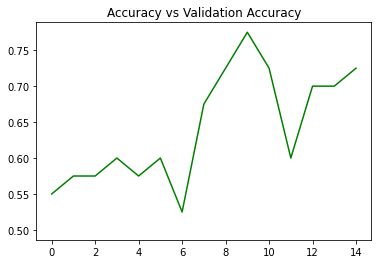

In [ ]:
plt.title("Accuracy vs Validation Accuracy")
plt.plot(h['accuracy'], c="green")
plt.plot(h['val_accuracy'], c="blue")
plt.show()

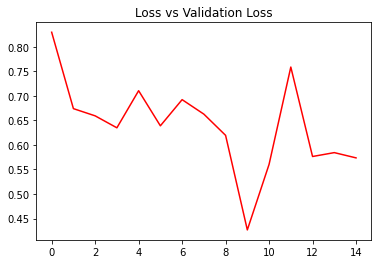

In [ ]:
plt.title("Loss vs Validation Loss")
plt.plot(h['loss'], c="red")
plt.plot(h['val_loss'], c="blue")
plt.show()

In [ ]:
model = load_model('/content/BestModel.h5')

In [ ]:
acc = model.evaluate_generator(test_data)[1]

print(f"Accuracy of Model is : { acc*100 }%")

Accuracy of Model is : 85.71428656578064%


In [ ]:
with_cancer = "/content/drive/MyDrive/Datasets/JPG_IMG/cancer/ID_0010_AGE_0060_CONTRAST_1_CT.jpg"
without_cancer = "/content/drive/MyDrive/Datasets/JPG_IMG/no_cancer/ID_0051_AGE_0063_CONTRAST_0_CT.jpg"

img = load_img(without_cancer, target_size=(224,224))
input_arr = img_to_array(img)

input_arr = np.expand_dims(input_arr, axis=0)

pred = math.floor(model.predict(input_arr)[0][0])
if pred == 0:
  print("Person is having Cancer")
else:
  print("Person is NOT having Cancer")



Person is having Cancer


In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
# from tensorflow.keras.applications.resnet import ResNet152, preprocess_input

def preprocessingImageForTL(path):
    """
    Input: Testing Images
    Output: Preprocessed Images
    """
    image_data = ImageDataGenerator( preprocessing_function=preprocess_input )
    image = image_data.flow_from_directory( directory=path, target_size=(224,224), batch_size=5, class_mode='binary' )
    return image

In [ ]:
mobilenet_base_model = MobileNet(input_shape=(224,224,3), include_top=False)
# resnet_base_model = ResNet152(input_shape=(224,224,3), include_top=False)

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
mobilenet_base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [ ]:
X = Flatten()(mobilenet_base_model.output)
X = Dense(units=1, activation="sigmoid")(X)

model = Model(mobilenet_base_model.input, X)

model.compile( optimizer="rmsprop", loss="binary_crossentropy", metrics=['accuracy'] )

In [ ]:
epochs = 30
steps_per_epochs = 8
verbose = 1
validation_steps = 5

mobilenet_best_history = model.fit_generator(
    train_data,
    steps_per_epoch=steps_per_epochs, 
    epochs=epochs, 
    verbose=verbose, 
    validation_data=val_data, 
    validation_steps=validation_steps, 
    callbacks= callBackES)

h = mobilenet_best_history.history
h.keys()

Epoch 1/30
8/8 [==============================] - 14s 1s/step - loss: 14.7285 - accuracy: 0.6000 - val_loss: 4.5662 - val_accuracy: 0.5000

Epoch 00001: accuracy did not improve from 0.77500
Epoch 2/30
8/8 [==============================] - 8s 965ms/step - loss: 8.8106 - accuracy: 0.6250

Epoch 00002: accuracy did not improve from 0.77500
Epoch 3/30
8/8 [==============================] - 8s 969ms/step - loss: 9.2343 - accuracy: 0.6000

Epoch 00003: accuracy did not improve from 0.77500
Epoch 4/30
8/8 [==============================] - 8s 961ms/step - loss: 5.4934 - accuracy: 0.6250

Epoch 00004: accuracy did not improve from 0.77500
Epoch 5/30
8/8 [==============================] - 8s 980ms/step - loss: 5.1519 - accuracy: 0.6750

Epoch 00005: accuracy did not improve from 0.77500
Epoch 6/30
8/8 [==============================] - 8s 969ms/step - loss: 2.7877 - accuracy: 0.6750

Epoch 00006: accuracy did not improve from 0.77500
Epoch 7/30
8/8 [==============================] - 8s 986ms/

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

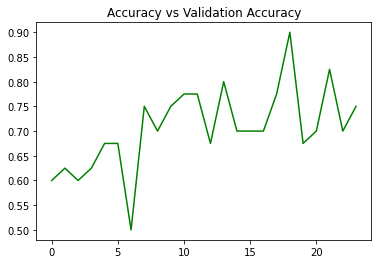

In [ ]:
bh = mobilenet_best_history.history
bh.keys()

plt.title("Accuracy vs Validation Accuracy")
plt.plot(bh['accuracy'], c="green")
plt.plot(bh['val_accuracy'], c="blue")
plt.show()

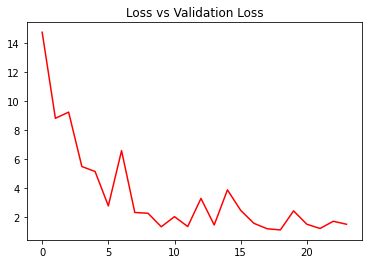

In [ ]:
plt.title("Loss vs Validation Loss")
plt.plot(bh['loss'], c="red")
plt.plot(bh['val_loss'], c="blue")
plt.show()

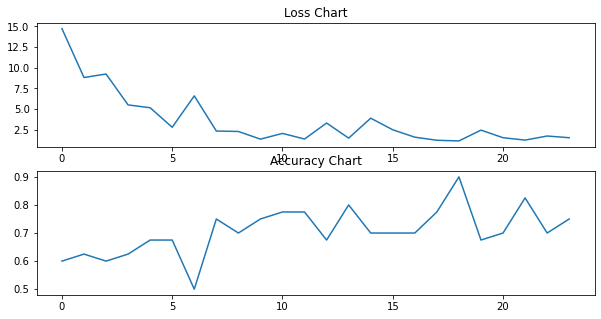

In [ ]:

fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(211)
ax1.plot(bh['loss'])
ax1.set_title("Loss Chart")

ax2 = fig.add_subplot(212)
ax2.plot(bh['accuracy'])
ax2.set_title("Accuracy Chart")

plt.show()

#Function to predict cancer

In [ ]:
def predictCancer(df):

  for i in df:
    img = load_img(i, target_size=(224,224))
    input_arr = img_to_array(img)

    input_arr = np.expand_dims(input_arr, axis=0)

    pred = model.predict(input_arr)[0][0]
    print("Prediction: "+str(round(pred*100, 2))+"%")
    pred = math.floor(pred)
    if pred == 0:
      print("Person is having Cancer\n\n")
    else:
      print("Person is NOT having Cancer\n\n")


#Predicting <b>WITH</b> cancer

In [ ]:

c = [
       "/content/drive/MyDrive/Datasets/JPG_IMG/cancer/ID_0000_AGE_0060_CONTRAST_1_CT.jpg",
       "/content/drive/MyDrive/Datasets/JPG_IMG/cancer/ID_0021_AGE_0067_CONTRAST_1_CT.jpg",
       "/content/drive/MyDrive/Datasets/JPG_IMG/cancer/ID_0038_AGE_0071_CONTRAST_1_CT.jpg"
]

"""
PREDICTING WITH CANCER IMAGES
"""
predictCancer(c)

Prediction: 100.0%
Person is having Cancer


Prediction: 0.23%
Person is having Cancer


Prediction: 81.45%
Person is having Cancer




#Predicting <b>WITHOUT</b> cancer

In [ ]:
w_c = [
       "/content/drive/MyDrive/Datasets/JPG_IMG/no_cancer/ID_0051_AGE_0063_CONTRAST_0_CT.jpg",
       "/content/drive/MyDrive/Datasets/JPG_IMG/no_cancer/ID_0091_AGE_0072_CONTRAST_0_CT.jpg",
       "/content/drive/MyDrive/Datasets/JPG_IMG/no_cancer/ID_0082_AGE_0047_CONTRAST_0_CT.jpg"
]

"""
PREDICTING WITH CANCER IMAGES
"""
predictCancer(w_c)

Prediction: 100.0%
Person is NOT having Cancer


Prediction: 100.0%
Person is NOT having Cancer


Prediction: 100.0%
Person is NOT having Cancer


